<a href="https://colab.research.google.com/github/felipecacique/Pytorch-Tutorial-Youtube/blob/main/Copy_of_nn_qda_features_Copy3_PYTORCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
# !tar xvzf ta-lib-0.4.0-src.tar.gz
# import os
# os.chdir('ta-lib') # Can't use !cd in co-lab
# !./configure --prefix=/usr
# !make
# !make install
# os.chdir('../')
# !pip install TA-Lib

## Notebook Instructions
<i>You can run the notebook document sequentially (one cell at a time) by pressing <b> shift + enter</b>. While a cell is running, a [*] will display on the left. When it has been run, a number will display indicating the order in which it was run in the notebook [8].</i>

<i>Enter edit mode by pressing <b>`Enter`</b> or using the mouse to click on a cell's editor area. Edit mode is indicated by a green cell border and a prompt showing in the editor area.</i> <BR>

## Create a NN model using PyTorch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [ ]:
# Create a model class that inherit nn.Module
class Model(nn.Module):
  # Input layer (4 features of the flower) -->
  # Hidden Layer1 (number of neurons) -->
  # H2 (n) -- >
  # output (3 classes of iris flowers)
  def __init__(self, in_features=4, h1=8, h2=9, out_features=3, dropout_prob=0.75):
    super().__init__() # instantiate our nn.Module
    self.fc1 = nn.Linear(in_features, h1)
    self.fc2 = nn.Linear(h1, h2)
    self.out = nn.Linear(h2, out_features)
    self.dropout = nn.Dropout(dropout_prob)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = self.out(x)

    return x

## Trading Strategy using Classification

The key steps involved in creating the strategy are:
1. Import data
2. Create indicators
3. Calculate returns
4. Train and test data
5. Create output signals
6. Create the Machine Learning Model
7. Predict the signals
8. Analyze the performance
9. Plot the results

### Import libraries

Next, we will import the necessary libraries for the strategy.

In [ ]:
# Import the libraries
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import joblib
import pickle
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import QuantileTransformer
from sklearn.naive_bayes import GaussianNB
import copy
# Technical indicator library
import talib as ta
from myfeatures import GetFeaturesSALIB_THX

## Import data

The 1-minute OHLCV data for the ICICI bank futures required for backtesting is saved in a CSV file, 'ICICI Minute Data.csv'. You can read this file and save it in a dataframe, Df.

To read a CSV file, you can use "pandas.read_csv()".

Syntax: pd.read_csv(filename)

filename: Name of the file in the string format

In [ ]:
# Read the CSV file
# Df = pd.read_csv("./petr4.tsv",delimiter="\t",decimal=".")
Df = pd.read_csv("./BTCUSD_Daily.csv",delimiter=",",decimal=".",dtype = {'Open': np.double, 'High': np.double, 'Low': np.double, 'Close': np.double})
Df.head()

,Time,Open,High,Low,Close,Volume
0,2011.03.23,0.83,0.90,0.83,0.87,14009
1,2011.03.24,0.87,0.89,0.86,0.88,4819
2,2011.03.25,0.88,0.91,0.84,0.86,11756
3,2011.03.26,0.83,0.87,0.82,0.82,5337
4,2011.03.27,0.82,0.85,0.76,0.80,12565


In [ ]:
Df["Time"].dtype

dtype('O')

In [ ]:
Df = Df.dropna()

In [ ]:
#Convert the 'Time' column into pandas datetime format
Df['Time'] = pd.to_datetime(Df['Time'],dayfirst=True)
Df.head()

<ipython-input-4606-a53a9ba261cb>:2: UserWarning: Parsing dates in %Y.%m.%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  Df['Time'] = pd.to_datetime(Df['Time'],dayfirst=True)


,Time,Open,High,Low,Close,Volume
0,2011-03-23,0.83,0.90,0.83,0.87,14009
1,2011-03-24,0.87,0.89,0.86,0.88,4819
2,2011-03-25,0.88,0.91,0.84,0.86,11756
3,2011-03-26,0.83,0.87,0.82,0.82,5337
4,2011-03-27,0.82,0.85,0.76,0.80,12565


In [ ]:
Df["Time"].dtype

dtype('<M8[ns]')

## Create Indicators

### Indicators using the SA lib

In [ ]:
def sa(df, params):
    # we need to rename the columns since the SA lib uses a diferent name
    df.rename(columns={'Time': 'time', 'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume'}, inplace=True)
    rates = df.to_dict("records")

    df_features = GetFeaturesSALIB_THX(rates,params)
    df_features = df_features.shift(1)

    df = pd.concat([df, df_features], axis=1)
    # let's change back the column's name
    df.rename(columns={'time': 'Time', 'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)
    df['Time'] = pd.to_datetime(df['Time'],dayfirst=True)
    return df

In [ ]:
# List with all possible features of the SA Lib
features_all = ['cto1', 'cto2', 'cto2',
                'ctc0', 'ctc1', 'ctc2', 'ctc3', 'ctc4', 'ctc5',
                'ctc0_label', 'ctc1_label', 'ctc2_label', 'ctc3_label', 'ctc4_label', 'ctc5_label',
                'ctc0_month','cto0_month',
                'fopen0', 'fhigh0', 'flow0', 'fhigh4', 'flow4', 'fhigh8', 'flow8', 'fhigh12', 'flow12',
                'ibs0', 'ibs1', 'ibs4', 'ibs8', 'ibs16',
                'gap', 'range0', 'range1', 'range_week0', 'range_week1', 'range_month0',
                'average_range_10', 'average_range_20', 'average_range_5',
                'average_failure_high', 'average_failure_low',
                'daily_position0', 'daily_position1', 'daily_position2', 'daily_position3',
                'weekly_position0','weekly_position1','weekly_position2',
                'relative_position0', 'minutes', 'hour', 'day', 'day_label',
                'quadrant',
                'cto1_label', 'cto2_label','cto3_label', 'cto4_label',
                'candle_id', 'ma_9_40_label', 'stoch_4_label', 'stoch_14_label', 'stoch_32_label',
                'stoch_4', 'stoch_14', 'stoch_32', 'adx_14', 'rsi_4', 'rsi_14', 'ma',
                'range_1', 'range_2', 'candle_return_1', 'candle_return_2',
                'cto1_h1', 'cto2_h1', 'cto2_h1', 'fopen0_h1', 'fhigh0_h1', 'flow0_h1', 'fhigh4_h1', 'flow4_h1',
                'ibs0_h1', 'ibs1_h1', 'ibs4_h1',]

# 'day_label' -> 0 if day<=10, 1 if 10<day<=20, 2 if 20<day<=31
# 'ctc0' -> %change between close0 to close1
# 'ctc0_label' -> if close0 >= close1 then label=0, if close0 < close1 then label=1
# 'ctc0_month' -> %change between the month close0 to the previous month close1
#  to crate a run of 3, you can instanciate 'ctc1_label', 'ctc2_label', 'ctc3_label'
# 'quadrant' -> 6 quadrants that are:
#                                     label=0 if day<=10 and monthly %change>=0,
#                                     label=1 if day<=10 and monthly %change<0,
#                                     label=2 if 10<day<=20 and monthly %change>=0,
#                                     label=3 if 10<day<=20 and monthly %change<0,
#                                     label=4 if 20<day<=31 and monthly %change>=0,
#                                     label=5 if 20<day<=31 and monthly %change<0,
#  if you want to use the absolute value of %change when instantiating the quadrant, you can use 'day_label' and 'ctc0_month'

In [ ]:
# params = ['hour', 'flow10', 'fhigh10', 'flow4', 'fhigh4', 'flow0', 'fhigh0']
params = ['quadrant']
Df = sa(Df, params)

Calculating indicators!!


In [ ]:
# Df = Df.dropna()
Df.head()

,Time,Open,High,Low,Close,Volume,quadrant
0,2011-03-23,0.83,0.90,0.83,0.87,14009,NaN
1,2011-03-24,0.87,0.89,0.86,0.88,4819,4.0
2,2011-03-25,0.88,0.91,0.84,0.86,11756,4.0
3,2011-03-26,0.83,0.87,0.82,0.82,5337,4.0
4,2011-03-27,0.82,0.85,0.76,0.80,12565,5.0


### Technical indicators using the TA lib

In [ ]:
# Create a variable n with a value of 10
n = 10

# # Create a column by name, RSI and assign the calculation of RSI to it
# Df['RSI'] = ta.RSI(np.array(Df['Close'].shift(1)), timeperiod=n)

# # Create a column by name, RSI and assign the calculation of RSI to it
# Df['RSI2'] = ta.RSI(np.array(Df['Close'].shift(1)), timeperiod=n*2)

# # Create a column by name, RSI and assign the calculation of RSI to it
# Df['RSI3'] = ta.RSI(np.array(Df['Close'].shift(1)), timeperiod=n*4)

# # Create a column by name, RSI and assign the calculation of RSI to it
# Df['RSI4'] = ta.RSI(np.array(Df['Close'].shift(1)), timeperiod=n*8)

# # Create a column by name, SMA and assign the SMA calculation to it
# Df['SMA'] = Df['Close'].shift(1).rolling(window=n).mean()

# # Create a column by name, SMA and assign the SMA calculation to it
# Df['SMA2'] = Df['Close'].shift(1).rolling(window=n*2).mean()

# # Create a column by name, SMA and assign the SMA calculation to it
# Df['SMA3'] = Df['Close'].shift(1).rolling(window=n*5).mean()

# # # Create a column by name, SAR and assign the SAR calculation to it
# # Df['SAR'] = ta.SAR(np.array(Df['High'].shift(1)), np.array(Df['Low'].shift(1)),
# #                    0.2, 0.2)

# Create a column by name, ADX and assign the ADX calculation to it
Df['ADX'] = ta.ADX(np.array(Df['High'].shift(1)), np.array(Df['Low'].shift(1)),
                   np.array(Df['Open']), timeperiod=n)


# Create columns 'OO' with the difference between the current minute's open and last minute's open
Df['OO'] = Df['Open']-Df['Open'].shift(1)

# # Create columns 'OC' with the difference between the current minute's open and last minute's close
# Df['OC'] = Df['Open']-Df['Close'].shift(1)

# # Create a column by name, MACD
# Df['MACD'], MACD_signal, Df['MACD_hist'] = ta.MACD(Df['Close'].shift(1), fastperiod=12, slowperiod=26, signalperiod=9)

# # Create a column by name, Stochastic
# Df['Slowk'], Slowd = ta.STOCH(Df['High'].shift(1), Df['Low'].shift(1), Df['Close'].shift(1), fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)


In [ ]:
Df = Df.dropna()
Df.head()

,Time,Open,High,Low,Close,Volume,quadrant,ADX,OO
20,2011-04-12,0.86,1.00,0.86,0.92,43397,2.0,69.901930,0.09
21,2011-04-13,0.92,1.00,0.91,1.00,31111,2.0,66.266222,0.06
22,2011-04-14,1.00,1.09,0.91,0.99,50304,2.0,62.994085,0.08
23,2011-04-15,0.98,1.10,0.95,1.05,28869,2.0,61.572050,-0.02
24,2011-04-16,1.05,1.14,1.03,1.11,24225,2.0,60.433157,0.07


## Calculate returns
Next, calculate the returns for every data point. We also save returns of past n minutes in n columns named as return1, return2 and so on. This will help the algorithm to understand the trend of the returns in the last n periods.  

In [ ]:
# Prediction horizon (candles)
pred_horizon = 1

# Create a column 'Fut_Ret' with the calculation of returns
Df['Ret'] = (Df['Open'].shift(-pred_horizon)-Df['Open'])/Df['Open']

# # Create n columns and assign
# for i in range(1, n):
#     Df['return%i' % i] = Df['Ret'].shift(i)

Df = Df.dropna()

<ipython-input-4614-f7ac7da202bd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Df['Ret'] = (Df['Open'].shift(-pred_horizon)-Df['Open'])/Df['Open']


## Train and test data

We will be using 80% of the data to train and the rest 20% to test. To do this, you will create a split parameter which will divide the dataframe in an 80-20 ratio.

This can be changed as per your choice, but it is advisable to give at least 70% data as train data for good results. "split" is the integer index value for the row corresponding to test-train split.

In [ ]:
pct_brincar = 1
#Para rodar da base inteira, comentar a linha abaixo e habilitar a linha de cima, com valor = 1
# Df = Df[:1000]
Df = Df[:int(pct_brincar*len(Df))]

In [ ]:
# Create a variable split which is 80% of the length of the Dataframe
t = .9
split = int(t*len(Df))
split

3457

## Create output signals

Next, assign signal values corresponding to 'returns' that were calculated earlier. To do this, you will split the data into three equal parts, using the split on 'Ret' column.
1. Highest returns’ quantile is assigned Signal '1' or "Buy".
2. Middle quantile is assigned Signal '0' or 'Do nothing'.
3. Lowest quantile is assigned Signal '-1' or 'Sell'.

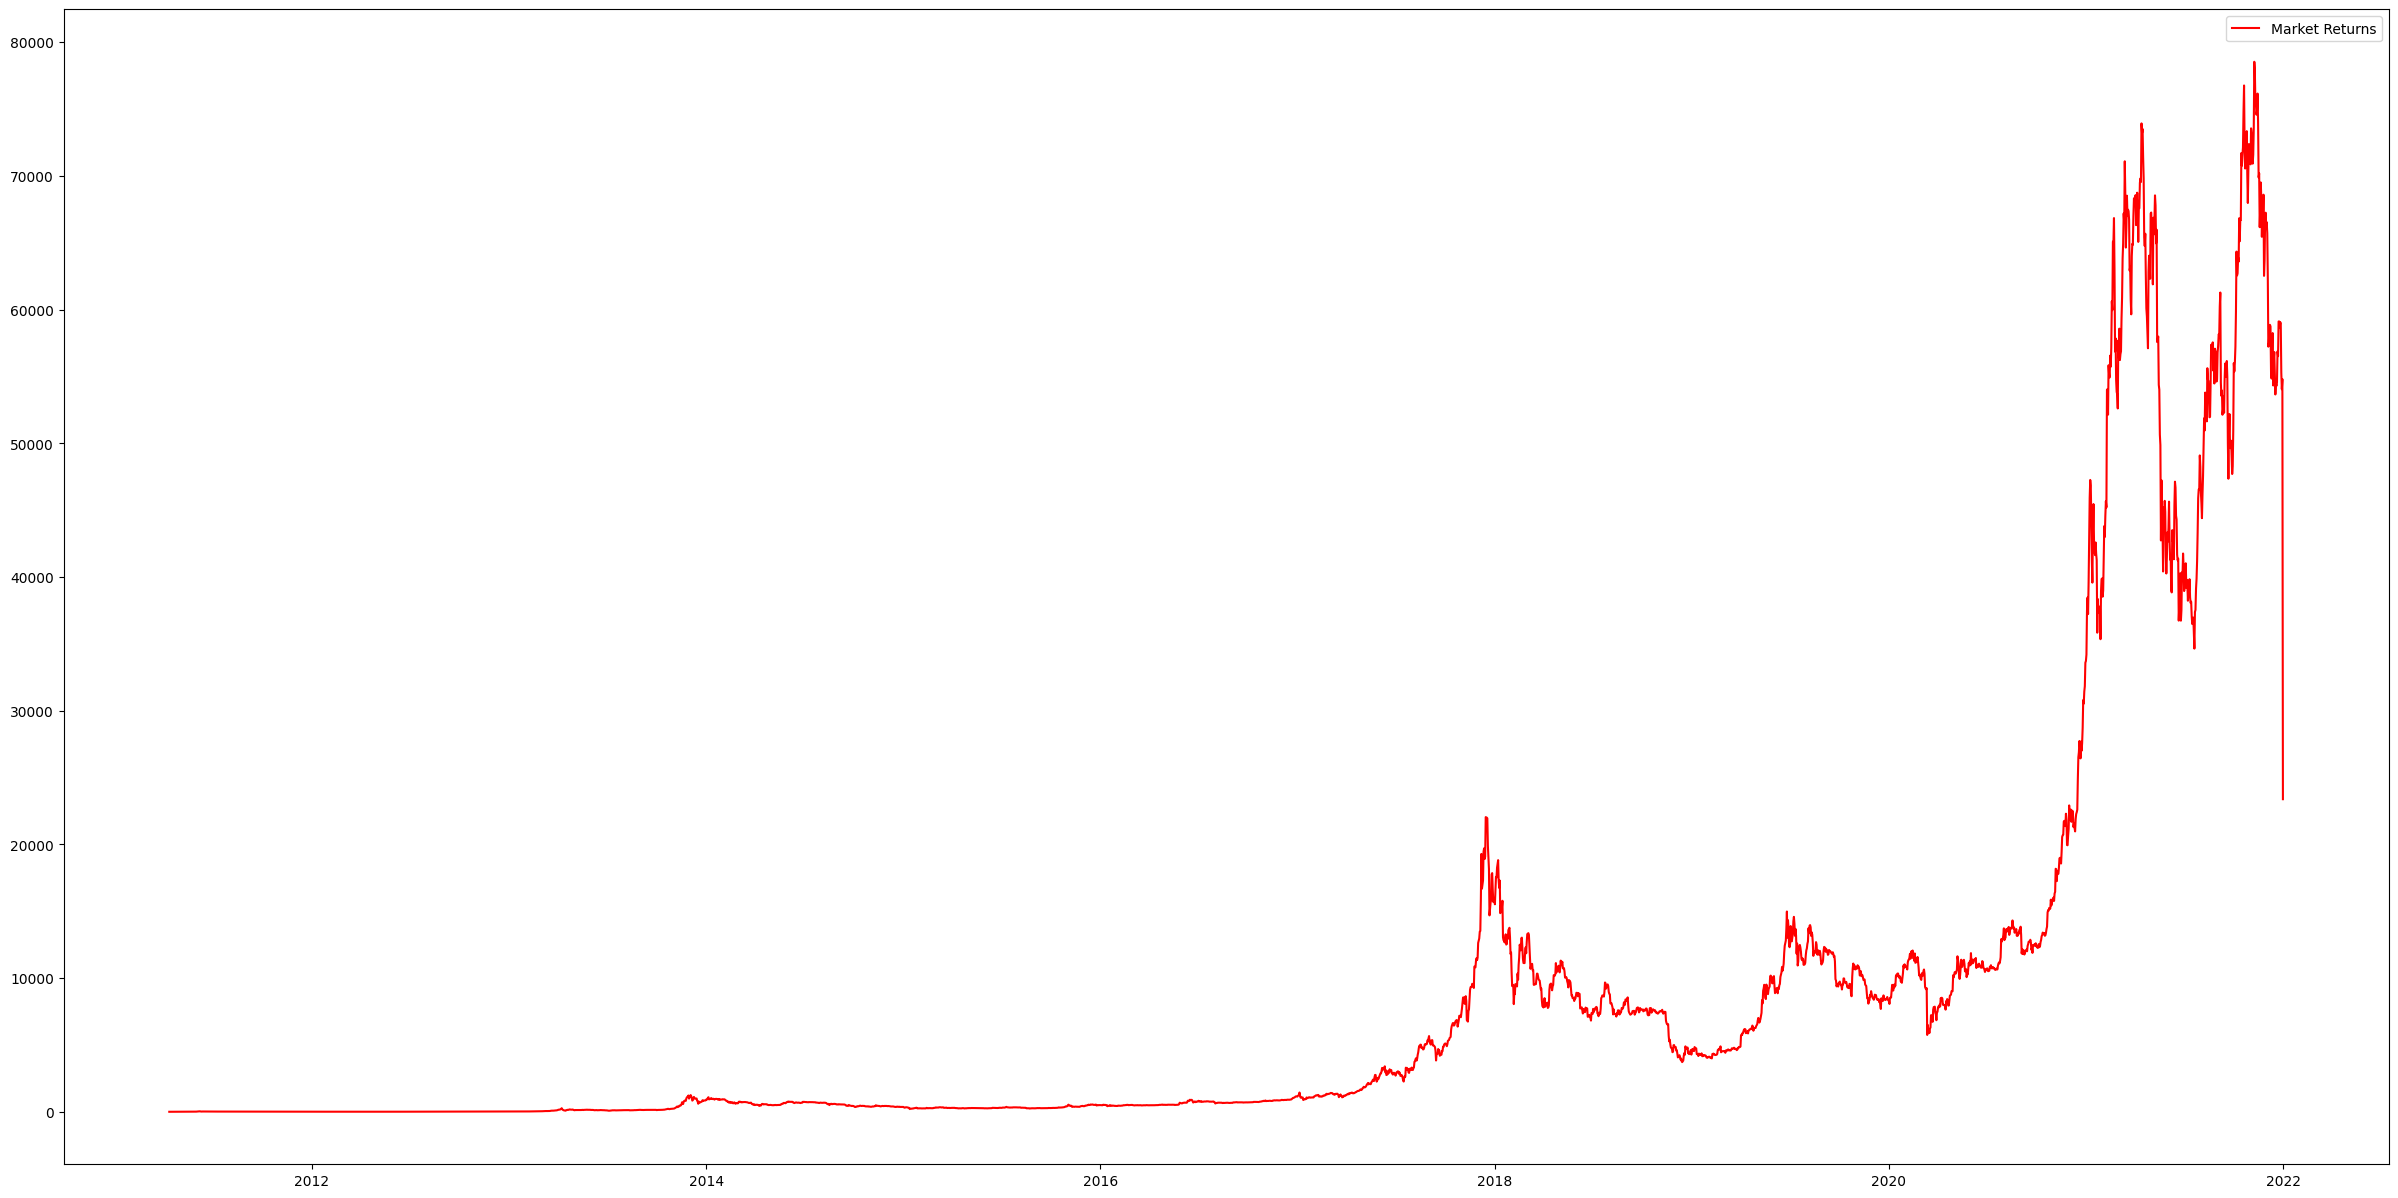

In [ ]:
Retdf = Df.copy()
Retdf.set_index("Time", inplace=True)

# Plot the strategy returns
plt.figure(figsize=(30,15))
plt.plot(((Retdf['Ret']+1).cumprod()),color='r',label='Market Returns')
plt.legend()
plt.show()

In [ ]:
# Create a column by name, 'Signal' and initialize with 0
Df['Signal']=0

# Assign a value of 1 to 'Signal' column for the quantile with highest returns
Df.loc[Df['Ret']>Df['Ret'][:split].quantile(q=0.66),'Signal']=1

# Assign a value of -1 to 'Signal' column for the quantile with lowest returns
Df.loc[Df['Ret']<Df['Ret'][:split].quantile(q=0.33),'Signal']=-1

In [ ]:
# # # It is necessary for daytrade only. If you are using daily candles, please comment the lines below

# # # Assign a value of 0 to 'Signal' column after 17h
# Df.loc[(Df['Time'].dt.hour>16), 'Signal']=0

# # Assign a value of 0 to 'Ret' column after 17h
# Df.loc[(Df['Time'].dt.hour>16), 'Ret']=0

One last step and then we will be ready with our data!  
### Creating the features and values

Drop the columns 'Close', 'Signal', 'Time', 'High', 'Low', 'Volume', and 'Ret' since the algorithm will not be trained on these features. Next, we assign 'Signal' to 'y' which is the output variable that you will predict using test data.   

In [ ]:
# Use df.drop() to drop the columns
X = Df.drop(['Ret',"Time","Signal"],axis=1)

X = Df.drop(['Ret',"Time","Signal", 'Close', 'Signal', 'High',
             'Low', 'Open', 'Volume', 'Ret'], axis=1)

# Create a variable which contains all the 'Signal' values
y = Df['Signal']
X.head()

,quadrant,ADX,OO
20,2.0,69.901930,0.09
21,2.0,66.266222,0.06
22,2.0,62.994085,0.08
23,2.0,61.572050,-0.02
24,2.0,60.433157,0.07


## Create the Machine Learning Model

### Create the new Machine Leaning Model

In this line of code we instantiate a new machine learning model.

In [ ]:
# Create a new QDA
cls = QuadraticDiscriminantAnalysis()

# Create a new MLP classifier
# cls = MLPClassifier(random_state=7, hidden_layer_sizes=(15,15,15), alpha=0.0001, activation='relu', max_iter=1000)

# Create a new Naive Bayes
# cls = GaussianNB()

### Train the data

We will first scale the data before you fit it to the classifier to train on. To do this, you need to first instantiate the Standard Scaler function.

In [ ]:
# Instantiate the StandardScaler
ss1 = StandardScaler()

# Instantiate the QuantileTransformer
# ss1 = QuantileTransformer()

You will use the scaled training data to train the classifier algorithm.

In [ ]:
# Pass the scaled train data to the SVC classifier
cls.fit(ss1.fit_transform(X.iloc[:split]),y.iloc[:split])

QuadraticDiscriminantAnalysis()

Epoch: 0 and loss: 1.162779688835144
Epoch: 10 and loss: 1.0952329635620117
Epoch: 20 and loss: 1.0914231538772583
Epoch: 30 and loss: 1.0928778648376465
Epoch: 40 and loss: 1.0909825563430786


Text(0.5, 0, 'Epoch')

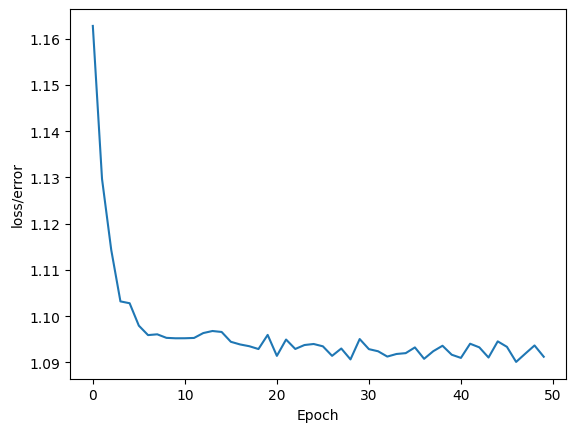

In [ ]:
# Training the PyTorch NN model

num_features = X.shape[1]
model = Model(in_features=num_features, h1=50, h2=50, out_features=3)

# Convert X features to float tensors
X_train = torch.FloatTensor(ss1.fit_transform(X.iloc[:split].to_numpy()))
y_train = torch.LongTensor(y.iloc[:split].to_numpy()+1)


# Set the criterion of model to measure the error, how far off the predictions are from the data
criterion = nn.CrossEntropyLoss()
# Chose Adam Optimizer, lr = learning rate (if error doesn't go sown after a bunch of iterations (epochs), lower our learning rate)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


# Train our model!
# Epochs? (one run thry all the training data in our network)
epochs = 50
losses = []
for i in range(epochs):
  # Go forward and get prediction
  y_pred = model.forward(X_train) # Get predicted results

  # Measure the loss/errorm gonna be right at first
  loss = criterion(y_pred, y_train) # predicted values vs the y_train

  # Keep Track of our losses
  losses.append(loss.detach().numpy()) # transform the loss format to arr

  # print every 10 epoch
  if i % 10 == 0:
    print(f'Epoch: {i} and loss: {loss}')

  # Do some back propagation: take the error rate of the forward propagation and feed it back
  # thru the network to fine tune the weight
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


# Graph it out!
plt.plot(range(epochs), losses)
plt.ylabel("loss/error")
plt.xlabel("Epoch")

Congratulations, your prediction model is ready!

In [ ]:
joblib.dump(ss1,'ss1.joblib')
joblib.dump(cls,'cls.joblib')

['cls.joblib']

## Predict the signals

Now, you can use the test data to make predictions and save the value of output 'y' in a list called 'y_predict'. This list will have the predicted values of 'Signal' for the test data.  

In [ ]:
ss1 = joblib.load('ss1.joblib')
cls = joblib.load('cls.joblib')

In [ ]:
# Pass the test data to the predict function and store the values into 'y_predict'
y_predict = cls.predict(ss1.transform(X.iloc[split:]))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [ ]:
# This is an alternative approach to generate the predictions.
# It uses the same method used in the ML framework, generates predictions based on a list of probability
# Please, uncomment the last line of this code block if you want to use it

y_prob = cls.predict_proba(ss1.transform(X.iloc[split:]))

def GetPredFromProb(y_prob, pred_threshold=0.56, pred_threshold2=1.0, mode=0):
    """This functions generates predictions based on a list of probability
    (e.g., we only buy if the probability of going up is very high)"""

    #--- In case we have only 2 classes
    if len(y_prob[0])==2: # in case we cave only 2 classes
        y_pred = [0 for y in y_prob]
        for i in range(0, len(y_pred)):
            prob_up = y_prob[i][1] / (y_prob[i][0]  + y_prob[i][1])
            prob_down = y_prob[i][0] / (y_prob[i][1] + y_prob[i][0])
            if prob_up >= pred_threshold:
                y_pred[i] = 1
            elif prob_down >= pred_threshold:
                y_pred[i] = -1
            else:
                y_pred[i] = 0
        return y_pred

    #--- In case we have 3 classes
    y_pred = [0 for y in y_prob]
    for i in range(0, len(y_pred)):

        if mode==0:
            # this way of calculating the probability yielded to much better results.
            # the prob of going up in the next few candles,
            # is the ArgMax() of the probability of being label 0 (going down)
            # and probability of being label 2 (going up), without taking
            # into account the probability of being label 1 (side)
            if (y_prob[i][0] + y_prob[i][2] != 0):
                prob_up = y_prob[i][2] / (y_prob[i][0] + y_prob[i][2])
            else:
                prob_up = 0

            if (y_prob[i][2] + y_prob[i][0]) != 0:
                prob_down = y_prob[i][0] / (y_prob[i][2] + y_prob[i][0])
            else:
                prob_down = 0
        else:
            prob_up = y_prob[i][2] / (y_prob[i][0] + y_prob[i][1] + y_prob[i][2])
            prob_down = y_prob[i][0] / (y_prob[i][2] + y_prob[i][1] + y_prob[i][0])

        if prob_up >= pred_threshold and y_prob[i][1] < pred_threshold2:  y_pred[i] = 1
        elif prob_down >= pred_threshold and y_prob[i][1] < pred_threshold2:  y_pred[i] = -1
        else:   y_pred[i] = 0
    return y_pred

# y_predict = GetPredFromProb(y_prob, pred_threshold=0.7)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [ ]:
# Predict the test using the PyTorch NN model

# Convert X features to float tensors
X_test = torch.FloatTensor(ss1.fit_transform(X.iloc[split:].to_numpy()))
y_test = torch.FloatTensor(y.iloc[split:].to_numpy())
y_predict = []
y_prob = []
correct = 0
with torch.no_grad():
  for i, data in enumerate(X_test):
    y_val = model.forward(data)
    y_predict.append(y_val.argmax().item() - 1)

    idx = y_val.argmax().item()
    y_prob.append( (1.6**y_val[idx]) / (1.6**y_val[0] + 1.6**y_val[1] + 1.6**y_val[2]) )
    if y_prob[-1] < 0.35:
      y_predict[-1] = 0

    # print(y_prob[-1])
    # Will tell us what type of flower class our network think it is
    # print(f'{i+1}: \t{str(y_val)} \t {y_val.argmax().item()} \t {y_test[i]}')

    # Correct or not
    if y_val.argmax().item() - 1 == y_test[i]:
      correct += 1

  print(f'We got {correct} correct of {len(X_test)}!')

y_predict = np.array(y_predict)
print(y_predict, len(y_predict))

We got 124 correct of 385!
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 1 1 0 0 0 1 0 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 1 1 1 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 1 0 1 0 0 1 1 1 1 1 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0
 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0] 385


In [ ]:
# Predict the test using the PyTorch NN model - TRAINING

# Convert X features to float tensors

y_predict_train = []
y_prob_train = []
correct = 0
with torch.no_grad():
  for i, data in enumerate(X_train):
    y_val = model.forward(data)
    y_predict_train.append(y_val.argmax().item() - 1)

    idx = y_val.argmax().item()
    y_prob_train.append( (1.6**y_val[idx]) / (1.6**y_val[0] + 1.6**y_val[1] + 1.6**y_val[2]) )
    if y_prob_train[-1] < 0.35:
      y_predict_train[-1] = 0

    # Will tell us what type of flower class our network think it is
    # print(f'{i+1}: \t{str(y_val)} \t {y_val.argmax().item()} \t {y_test[i]}')

    # Correct or not
    if y_val.argmax().item() - 1 == y_train[i]:
      correct += 1

  print(f'We got {correct} correct of {len(X_train)}!')

y_predict_train = np.array(y_predict_train)
print(y_predict_train, len(y_predict_train))

We got 1071 correct of 3457!
[1 0 1 ... 1 0 0] 3457


Now create a new column 'Pred_Signal' in 'Df' to save all the predictions for both train data and test data.

In [ ]:
# Initiate a column by name, 'Pred_Signal' and assign 0 to it
Df['Pred_Signal'] = 0

### Save the predictions
1. To save predicted 'y' values of test data, we can simply assign 'y_predict' to 'Pred_Signal' using the split.
2. To save predicted 'y' values for train data, we make predictions for train data and save it similarly.

In [ ]:
# Save the predicted values for the train data
# Df.iloc[:split,Df.columns.get_loc('Pred_Signal')] = pd.Series(cls.predict(ss1.transform(X.iloc[:split])).tolist())
# Df.iloc[:split,Df.columns.get_loc('Pred_Signal')] = cls.predict(ss1.transform(X.iloc[:split]))
Df.iloc[:split,Df.columns.get_loc('Pred_Signal')] = y_predict_train

# Save the predicted values for the test data
Df.iloc[split:,Df.columns.get_loc('Pred_Signal')] = y_predict

Df['Profit'] = Df['Pred_Signal']*Df['Ret']

In [ ]:
Df["Test_Set"] = 0
Df.loc[split:,"Test_Set"] = 1
Df.to_csv("output_pred.csv")

Since, the algorithm was trained on the train data, it’s accuracy of prediction is expected to be better on this train data compared to the test data. You can print these two seperately to check the accuracies. (TRY ON YOUR OWN!)

## Use the model for trading strategy

### Trading strategy
        
Our trading strategy is simply to buy/sell/do-nothing at that period for which the Signal is generated by the algorithm. The strategy assumes that you always get a fill at the "Open" prices.

You had already calculated and saved returns on 'Open' prices in 'Ret'. You will create a column named 'Ret1' to store the strategy's returns based on the Signal.

In [ ]:
# Calculate strategy returns and store them in 'Ret1' column
Df['Ret1'] = Df['Ret']*Df['Pred_Signal']

## Analyze the performance

Please note that here you are using only the test data to compare the performance of the strategy. You can pass the entire 'Ret1' column and check the performance on both the test and train data if you wish to.

In [ ]:
# Calculate the annualized Sharpe ratio
sharpe = np.sqrt(252) * Df['Ret1'][split:].mean() / Df['Ret1'][split:].std()

print('Sharpe', sharpe)

Sharpe 1.3605005048740053


In [ ]:
# Calculate other metrics

def CalculateMetrics(returns,y_pred,dates,optimize=False,prediction_horizon=1,type_='percentual'):
    #Receive the dates, predictions and returns, apply a simple trading strategy (exit position after n candles, without tp and sl), and show the results and graph"""

    #--- get the returns if we follow the strategy (follow the prediction signals) - it is equivalent to buying or selling according to the signal, and keep the position for n candles. We can have multiple positions at the same time, without sl and tp
    strategy_returns=[y_pred[i]*returns[i] for i in range(0,len(y_pred))]

    #--- get the cumulative return of our strategy - increasing position - juros composto
    strategy_accumulated_prod = 1
    for i in range(1, len(strategy_returns)):
        strategy_accumulated_prod *= (strategy_returns[i]+1)
    strategy_accumulated_prod -= 1

    #--- get the cumulative return of our strategy
    strategy_accumulated = copy.copy(strategy_returns)
    for i in range(1, len(strategy_accumulated)):
        strategy_accumulated[i] = strategy_accumulated[i-1] + strategy_returns[i]

    #--- get the cumulative return of the asset - where we buy only, at every candle, and keeps the position opened for n candles
    asset_accumulated = copy.copy(returns)
    for i in range(1, len(asset_accumulated)):
        asset_accumulated[i] = asset_accumulated[i-1] + returns[i]


    #--- get the cumulative loss of our strategy - draw down
    strategy_drawdown = copy.copy(strategy_returns)
    for i in range(1, len(strategy_drawdown)):
        strategy_drawdown[i] = (strategy_drawdown[i-1] + strategy_returns[i] if strategy_drawdown[i-1] + strategy_returns[i] < 0 else 0)

    drawdown_max = np.min(np.array(strategy_drawdown))
    drawdown_mean = np.mean(np.array(strategy_drawdown))
    total_return = strategy_accumulated[-1]
    total_days = len(list(set([date.strftime("%Y-%m-%d") for date in dates])))
    total_months = total_days / 21
    monthly_return = (total_return/total_months if total_months>0 else 0)
    drawdown_max_by_monthly_return = (-drawdown_max/monthly_return if monthly_return != 0 else 0)
    drawdown_mean_by_monthly_return = (-drawdown_mean/monthly_return if monthly_return != 0 else 0)


    #--- calculating a few metrics

    if optimize:
        e = []
        for i,pred in enumerate(y_pred):
            if y_pred[max(0,i-prediction_horizon)] != pred: e.append(abs(pred))
        entries = np.sum(np.array(e))
    else:
        entries = np.sum(np.array([abs(pred) for pred in y_pred]))
        entries_buy = int(np.sum(np.array([abs(pred) for pred in y_pred if pred>0])))
        entries_sell = int(np.sum(np.array([abs(pred) for pred in y_pred if pred<0])))
    total_return = strategy_accumulated[-1]
    if entries>0:
        return_per_entry = total_return / entries
    else:
        return_per_entry = 0

    poss = sum([1 for return_ in strategy_returns if return_ > 0])
    negs = sum([1 for return_ in strategy_returns if return_ < 0])
    success = (poss+1) / (poss + negs+2)

    poss_ = sum([return_ for return_ in strategy_returns if return_ > 0])
    negs_ = sum([return_ for return_ in strategy_returns if return_ < 0])
    profitFactor = -((poss_+0.000001)/(negs_+0.000001))

    if type_ == 'percentual':
        print(
              "\n \tTotal return: ",round(total_return*100,4),"%",
              "\n \tEntries: ", entries,
              "\n \tReturn per entry: ", round(return_per_entry*100,4),"%",
              "\n \tSuccess: ", round(success*100,2),"%",
              "\n \tRatio: ", round(profitFactor,2),
              "\n \tTotal of days: ", total_days,
              "\n \tTotal of months: ", round(total_months,4),
              "\n \tMonthly return: ", round(monthly_return*100,4),"%",
              "\n \tMax drawdown: ", round(drawdown_max*100,4),"%",
              "\n \tMean drawdown: ", round(drawdown_mean*100,4),"%",
              "\n \tBuy signals", entries_buy,
              "\n \tSell signals", entries_sell,
              )
    else:
        print(
              "\n \tTotal return: ",round(total_return,4),
              "\n \tEntries: ", entries,
              "\n \tReturn per entry: ", round(return_per_entry,4),
              "\n \tSuccess: ", round(success*100,2),"%",
              "\n \tRatio: ", round(profitFactor,2),
              "\n \tTotal of days: ", total_days,
              "\n \tTotal of months: ", round(total_months,4),
              "\n \tMonthly return: ", round(monthly_return,4),
              "\n \tMax drawdown: ", round(drawdown_max,4),
              "\n \tMean drawdown: ", round(drawdown_mean,4),
              "\n \tBuy signals", entries_buy,
              "\n \tSell signals", entries_sell,
              )

# Strategy Metrics
returns = list(Df['Ret'][split:])
y_pred = list(Df['Pred_Signal'][split:])
dates = list(Df['Time'][split:])
print("\nStrategy results %: ")
CalculateMetrics(returns,y_pred,dates,type_='percentual')

returns_absolute = list((Df['Ret']*Df['Open'])[split:])
print("\nStrategy results: ")
CalculateMetrics(returns_absolute,y_pred,dates,type_='points')



# BuyOnlyBaseline
returns = list(Df['Ret'][split:])
y_pred = [1]*len(returns)
dates = Df['Time'][split:]
print("\nBuy Only (Baseline) results %: ")
CalculateMetrics(returns,y_pred,dates)

returns_absolute = list((Df['Ret']*Df['Open'])[split:])
print("\nBuy Only (Baseline) results: ")
CalculateMetrics(returns_absolute,y_pred,dates,type_='points')


Strategy results %: 

 	Total return:  61.0369 % 
 	Entries:  69 
 	Return per entry:  0.8846 % 
 	Success:  52.11 % 
 	Ratio:  1.73 
 	Total of days:  385 
 	Total of months:  18.3333 
 	Monthly return:  3.3293 % 
 	Max drawdown:  -22.0633 % 
 	Mean drawdown:  -2.984 % 
 	Buy signals 69 
 	Sell signals 0

Strategy results: 

 	Total return:  26231.024 
 	Entries:  69 
 	Return per entry:  380.1598 
 	Success:  52.11 % 
 	Ratio:  1.74 
 	Total of days:  385 
 	Total of months:  18.3333 
 	Monthly return:  1430.7831 
 	Max drawdown:  -8471.267 
 	Mean drawdown:  -1472.0368 
 	Buy signals 69 
 	Sell signals 0

Buy Only (Baseline) results %: 

 	Total return:  73.1703 % 
 	Entries:  385 
 	Return per entry:  0.1901 % 
 	Success:  52.45 % 
 	Ratio:  1.12 
 	Total of days:  385 
 	Total of months:  18.3333 
 	Monthly return:  3.9911 % 
 	Max drawdown:  -90.4179 % 
 	Mean drawdown:  -19.4272 % 
 	Buy signals 385 
 	Sell signals 0

Buy Only (Baseline) results: 

 	Total return:  2071.893 
 	

## Plot the results

Now you can plot the results to visualize the performance.


In [ ]:
Df.set_index("Time", inplace=True)

### Traning period

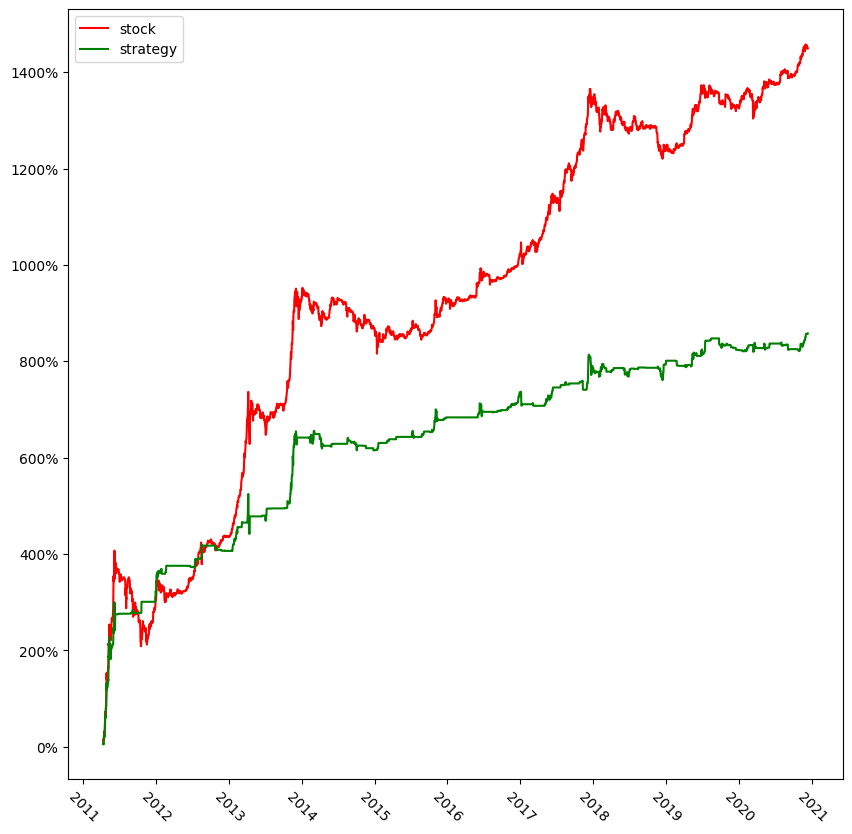

In [ ]:
# Plot the strategy returns in the test period
plt.figure(figsize=(10,10))
# plt.plot(((Df['Ret'][:split]+1).cumprod()-1),color='r',label='Mini-índice')
# plt.plot(((Df['Ret1'][:split]+1).cumprod()-1),color='g',label='Estratégia')
plt.plot(((Df['Ret'][:split]).cumsum()),color='r',label='stock')
plt.plot(((Df['Ret1'][:split]).cumsum()),color='g',label='strategy')
plt.legend()
plt.xticks(rotation=-45)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

### Testing period

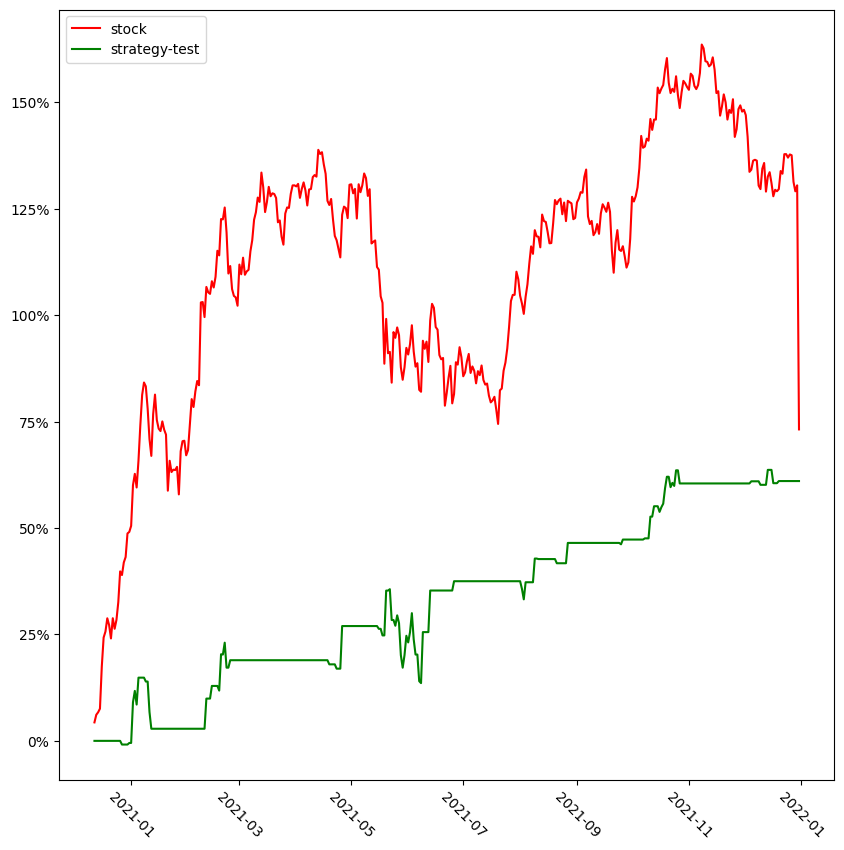

In [ ]:
# Plot the strategy returns in the test period
plt.figure(figsize=(10,10))
# plt.plot(((Df['Ret'][split:]+1).cumprod()-1),color='r',label='Mini-índice')
# plt.plot(((Df['Ret1'][split:]+1).cumprod()-1),color='g',label='Estratégia')
plt.plot(((Df['Ret'][split:]).cumsum()),color='r',label='stock')
plt.plot(((Df['Ret1'][split:]).cumsum()),color='g',label='strategy-test')
plt.legend()
plt.xticks(rotation=-45)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

## Now, it's your turn!

### Tweak the code

You can tweak the code in the following ways:
1. Use different data sets – backtest and try out the model on different data sets!
2. Features – create your own features using different indicators that could improve the prediction accuracy



### Prediction with a new data
Getting new data

In [ ]:
# Pass the new data in the format of a dictionary, with the same keys and orders from the datased used for training
new_data = {'O':[70100], 'F1':[-0.025238], 'F2':[-0.002561], 'F3':[-0.002987], 'F4':[0.00000], 'F5':[-0.025238],'F6':[-0.025238],'F7':[-0.025238]}

# Transform the dictionary into a dataframe
x = pd.DataFrame(new_data)
print(x)

       O        F1        F2        F3   F4        F5        F6        F7
0  70100 -0.025238 -0.002561 -0.002987  0.0 -0.025238 -0.025238 -0.025238


Doing the prediction of the new data using the previously trained model

In [ ]:
Pass the new data to the predict function and store the values into 'y_predict'
y_predict = cls.predict(ss1.transform(x))
print('Prediction: ', y_predict)

SyntaxError: invalid syntax (<ipython-input-4641-bff4d03351c7>, line 1)